In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import splitfolders
import matplotlib.pyplot as plt
import shutil

from ultralytics import YOLO

In [7]:
def rm_folder_if_exists(folder):
    if os.path.exists(folder):
        try:
            shutil.rmtree(folder)
        except OSError as e:
            print("Error: %s - %s." % (e.filename, e.strerror))

In [8]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Setup complete. Using torch {torch.__version__} ({DEVICE})")

Setup complete. Using torch 2.6.0+cu124 (cuda:0)


In [9]:
splitfolders.ratio('./HumanDetection/heridal', output='./HumanDetection/heridal_split/images',
                seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 1546 files [00:01, 787.83 files/s]


In [10]:
TRAIN_DATA_DIR = './HumanDetection/heridal_split/images/train/class0'
VAL_DATA_DIR = './HumanDetection/heridal_split/images/val/class0'

IM_WIDTH = 4000
IM_HEIGHT = 3000

EPOCHS = 100

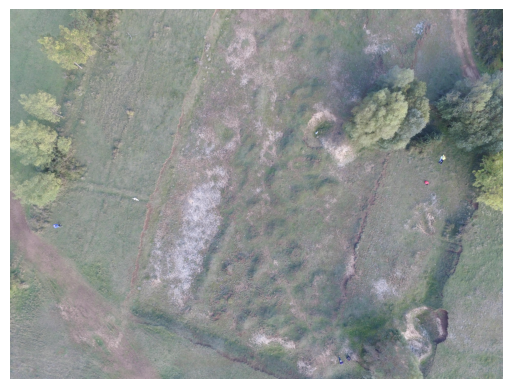

In [24]:
test_img = TRAIN_DATA_DIR + '/train_BLA_0002_JPG.rf.1e82cab69709e084d88eed66b0aa2a88.jpg' 

img = cv2.imread(test_img)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [12]:
df = pd.read_csv('./HumanDetection/heridal/_annotations.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,train_BRA_1012_JPG.rf.fa0e8bf1e58b462173e12dd6...,4000,3000,human,754,1012,791,1046
1,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,1910,1258,1949,1294
2,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,966,1900,1016,1931
3,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,1564,2624,1604,2676
4,train_BRK_2092_JPG.rf.fc6ba9e5aa512819b66ef089...,4000,3000,human,2578,1010,2658,1079


In [13]:
df = df.replace('human', 0)
df.head()

/tmp/ipykernel_637308/1064772545.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('human', 0)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,train_BRA_1012_JPG.rf.fa0e8bf1e58b462173e12dd6...,4000,3000,0,754,1012,791,1046
1,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,1910,1258,1949,1294
2,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,966,1900,1016,1931
3,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,1564,2624,1604,2676
4,train_BRK_2092_JPG.rf.fc6ba9e5aa512819b66ef089...,4000,3000,0,2578,1010,2658,1079


In [14]:
print(df['class'].unique())
print(df['width'].unique())
print(df['height'].unique())

[0]
[4000]
[3000]


In [15]:
LABELS_DIR_TRAIN = './HumanDetection/heridal_split/labels/train/class0'
LABELS_DIR_VAL = './HumanDetection/heridal_split/labels/val/class0'
os.makedirs(LABELS_DIR_TRAIN, exist_ok=True)
os.makedirs(LABELS_DIR_VAL, exist_ok=True)

In [ ]:
# TODO: Need to pass all the labels, only the first gets chosen for now.

for index, row in df.iterrows():
    img_train = os.path.join(TRAIN_DATA_DIR, row['filename'])

    if os.path.exists(img_train):
        txt_path = os.path.join(LABELS_DIR_TRAIN, os.path.splitext(row['filename'])[0] + '.txt')
    else:
        txt_path = os.path.join(LABELS_DIR_VAL, os.path.splitext(row['filename'])[0] + '.txt')
    
    img_width = row['width']
    img_height = row['height']

    with open(txt_path, 'w') as f:
        class_id = row['class']
        x_center = ((row['xmin'] + row['xmax']) / 2) / img_width
        y_center = ((row['ymin'] + row['ymax']) / 2) / img_height
        width = (row['xmax'] - row['xmin']) / img_width
        height = (row['ymax'] - row['ymin']) / img_height
        
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

In [16]:
with open('./HumanDetection/heridal_split/labels/train/class0/train_BLA_0002_JPG.rf.1e82cab69709e084d88eed66b0aa2a88.txt', 'r') as f:
    print(f.read())

0 0.876500 0.407833 0.014500 0.029667



In [18]:
rm_folder_if_exists('./runs/detect/yolo11m_heridal')

In [19]:
model = YOLO('yolo11m.pt')

results = model.train(
    data='./HumanDetection/heridal.yaml',
    epochs=200,
    device=DEVICE,
    imgsz=1024,
    batch=4,
    name='yolo11m_heridal'
)

New https://pypi.org/project/ultralytics/8.3.128 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./HumanDetection/heridal.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_heridal, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, 

train: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/train/class0.cache... 788 images, 448 backgrounds, 0 corrupt: 100%|██████████| 1236/1236 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3743.7±2347.0 MB/s, size: 3501.9 KB)


val: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/val/class0.cache... 197 images, 113 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11m_heridal/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/yolo11m_heridal
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      5.09G      2.507      5.058      1.113          4       1024: 100%|██████████| 309/309 [00:46<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.35it/s]

                   all        310        197      0.188      0.218      0.119     0.0281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      5.46G      2.833      2.967      1.173          8       1024: 100%|██████████| 309/309 [00:45<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.15it/s]

                   all        310        197      0.157      0.289      0.105     0.0268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      5.53G       2.67      2.674      1.136          4       1024: 100%|██████████| 309/309 [00:45<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.17it/s]

                   all        310        197      0.153      0.294      0.118      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200       5.6G      2.669      2.782      1.137          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.40it/s]

                   all        310        197      0.228      0.314      0.157     0.0436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      5.66G      2.626       2.72      1.107          4       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.38it/s]

                   all        310        197      0.246      0.249      0.159     0.0436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      5.66G      2.652      2.638       1.14          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.31it/s]

                   all        310        197      0.189      0.437      0.171     0.0458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      5.66G      2.546      2.532      1.098          1       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.57it/s]

                   all        310        197      0.229      0.411      0.179     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      5.66G      2.508       2.52      1.083          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.11it/s]

                   all        310        197      0.289      0.396      0.259     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      5.66G       2.45      2.545      1.065          2       1024: 100%|██████████| 309/309 [00:45<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.45it/s]

                   all        310        197      0.221      0.381      0.187     0.0584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      5.67G       2.48      2.531      1.096          0       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.10it/s]

                   all        310        197      0.284      0.416      0.248     0.0886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      5.67G      2.365      2.412      1.072          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.09it/s]

                   all        310        197      0.288      0.436      0.243     0.0772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      5.67G      2.361      2.345      1.059          8       1024: 100%|██████████| 309/309 [00:45<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.12it/s]

                   all        310        197      0.325      0.443      0.285     0.0882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      5.67G      2.364      2.329      1.064          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.16it/s]

                   all        310        197      0.309      0.523       0.32       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      5.67G      2.333      2.288      1.054          1       1024: 100%|██████████| 309/309 [00:44<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.98it/s]

                   all        310        197      0.294      0.294      0.227     0.0657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      5.67G      2.292      2.215      1.041          2       1024: 100%|██████████| 309/309 [00:44<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.46it/s]

                   all        310        197      0.359      0.492      0.347      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      5.67G      2.353      2.252      1.049          3       1024: 100%|██████████| 309/309 [00:45<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.56it/s]

                   all        310        197      0.336      0.421      0.287     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      5.67G      2.277      2.143      1.042          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.44it/s]

                   all        310        197      0.319      0.381      0.247      0.084



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      5.73G      2.325      2.234      1.063          6       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.62it/s]

                   all        310        197      0.329      0.477      0.303      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      5.74G      2.261      2.178      1.008          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.23it/s]

                   all        310        197      0.339      0.455        0.3     0.0943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      5.74G      2.227      2.103      1.028          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.27it/s]

                   all        310        197      0.354      0.437        0.3      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      5.74G      2.278      2.236      1.029          8       1024: 100%|██████████| 309/309 [00:45<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.38it/s]

                   all        310        197      0.333      0.513      0.311      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      5.74G      2.208      2.031      1.022          4       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.38it/s]

                   all        310        197      0.372      0.421      0.305      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      5.74G      2.178      2.121      1.022          2       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.29it/s]

                   all        310        197      0.407      0.355      0.315       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      5.74G      2.126      2.025       1.02          6       1024: 100%|██████████| 309/309 [00:45<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.23it/s]

                   all        310        197       0.41      0.452      0.371      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      5.74G      2.229      2.137      1.029          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.35it/s]

                   all        310        197      0.409      0.487      0.354      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      5.74G      2.156      2.109      1.016          7       1024: 100%|██████████| 309/309 [00:45<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.19it/s]

                   all        310        197      0.353      0.457       0.34      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      5.74G      2.173      2.083      1.003          6       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.36it/s]

                   all        310        197      0.427      0.462      0.359      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      5.74G       2.11      2.038       1.01          1       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.62it/s]

                   all        310        197      0.317      0.477      0.344      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      5.74G      2.095       1.92     0.9933          7       1024: 100%|██████████| 309/309 [00:45<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.59it/s]

                   all        310        197      0.426      0.477      0.414       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      5.74G      2.139      1.992     0.9941          2       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.57it/s]

                   all        310        197      0.423      0.492      0.367      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      5.74G      2.116      2.014     0.9886          6       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.58it/s]

                   all        310        197      0.377      0.487      0.363      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      5.74G      2.096      2.007     0.9757          7       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.42it/s]

                   all        310        197      0.406      0.513      0.373      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      5.74G      2.092       1.96     0.9988          4       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.67it/s]

                   all        310        197      0.464      0.533      0.404      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      5.74G      2.094      2.017     0.9866          5       1024: 100%|██████████| 309/309 [00:45<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.48it/s]

                   all        310        197       0.47      0.481      0.419      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      5.74G      2.024      1.798     0.9656          7       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.54it/s]

                   all        310        197       0.41      0.518      0.408       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      5.74G      2.029      1.941     0.9916          3       1024: 100%|██████████| 309/309 [00:45<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.41it/s]

                   all        310        197      0.498      0.508      0.443      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      5.74G      2.035      1.887     0.9607          4       1024: 100%|██████████| 309/309 [00:45<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.47it/s]

                   all        310        197      0.439      0.467      0.401      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      5.74G      2.093      1.984     0.9944          2       1024: 100%|██████████| 309/309 [00:45<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.36it/s]

                   all        310        197      0.519      0.492      0.448      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      5.74G      2.021       1.95     0.9871          4       1024: 100%|██████████| 309/309 [00:45<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.37it/s]

                   all        310        197      0.495      0.513       0.41      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      5.74G      1.999      1.811     0.9702          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.15it/s]

                   all        310        197      0.474      0.467       0.41       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      5.74G      2.035      1.874     0.9836          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.479      0.584      0.466      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      5.74G      2.028      1.978     0.9828          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.34it/s]

                   all        310        197      0.384      0.492      0.373      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      5.74G      2.025      1.901     0.9864          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.27it/s]

                   all        310        197      0.378      0.396      0.329      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      5.74G      2.034      1.917      1.002          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.27it/s]

                   all        310        197      0.447      0.482      0.433      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200       5.4G          2      1.826     0.9877          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.33it/s]

                   all        310        197      0.412      0.482      0.398      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      5.71G      1.907      1.677     0.9527          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.24it/s]

                   all        310        197      0.492      0.548      0.487      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      5.72G      1.991      1.947     0.9693          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.30it/s]

                   all        310        197      0.541       0.52      0.493      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      5.79G      1.979      1.836     0.9536          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.33it/s]

                   all        310        197      0.475      0.503      0.465      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      5.86G      1.892      1.691     0.9395          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.17it/s]

                   all        310        197      0.462      0.528      0.437      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      5.28G      1.976      1.767     0.9652          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.17it/s]

                   all        310        197      0.459      0.467      0.443      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      5.64G      1.964      1.772     0.9533          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.04it/s]

                   all        310        197      0.487      0.513      0.489      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      5.71G      1.905      1.756      0.959          7       1024: 100%|██████████| 309/309 [00:43<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.479      0.579      0.506      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      5.78G      1.914       1.72     0.9583          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.26it/s]

                   all        310        197      0.493      0.553      0.485      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      5.84G      1.889      1.699      0.933          2       1024: 100%|██████████| 309/309 [00:45<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.56it/s]

                   all        310        197      0.465      0.584      0.496      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      5.84G      1.899      1.635       0.95          1       1024: 100%|██████████| 309/309 [00:45<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.41it/s]

                   all        310        197      0.496      0.523      0.477      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      5.84G      1.847      1.695     0.9398          2       1024: 100%|██████████| 309/309 [00:44<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.495      0.538        0.5      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      5.84G       1.95      1.785     0.9492          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.20it/s]

                   all        310        197      0.486      0.504      0.446       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      5.84G      1.859      1.723     0.9377          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.29it/s]

                   all        310        197      0.485      0.584      0.498      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      5.84G        1.9       1.68     0.9626          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.18it/s]

                   all        310        197      0.506      0.518      0.462      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      5.84G       1.87      1.697     0.9451          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]

                   all        310        197      0.523      0.416      0.441      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      5.84G      1.905      1.714     0.9612          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.17it/s]

                   all        310        197      0.503      0.553      0.503      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      5.84G      1.839      1.639     0.9266          7       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.33it/s]

                   all        310        197      0.469      0.548      0.458      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      5.38G       1.84      1.658     0.9424          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.31it/s]

                   all        310        197       0.41      0.543      0.428      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      5.68G      1.822      1.659      0.928          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.12it/s]

                   all        310        197      0.513      0.503      0.484      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      5.73G      1.835      1.639     0.9463          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.26it/s]

                   all        310        197      0.483       0.64       0.51      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       5.8G      1.924      1.792     0.9658          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.20it/s]

                   all        310        197      0.458      0.599      0.472      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      5.87G      1.814      1.663      0.928          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.10it/s]

                   all        310        197      0.521      0.546      0.521      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      5.37G       1.84      1.616     0.9542          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.16it/s]

                   all        310        197      0.475      0.584       0.48      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      5.68G      1.786      1.635      0.939          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.12it/s]

                   all        310        197      0.533      0.533      0.473      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      5.73G      1.817      1.659     0.9309          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.26it/s]

                   all        310        197      0.466      0.614        0.5      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200       5.8G      1.899      1.638     0.9544          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.12it/s]

                   all        310        197      0.497      0.563      0.494       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      5.86G      1.798      1.521     0.9287          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.09it/s]

                   all        310        197       0.54      0.547      0.502       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      5.37G      1.793       1.54     0.9503          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.24it/s]

                   all        310        197      0.604      0.528      0.516      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      5.67G      1.763      1.522      0.926          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.20it/s]

                   all        310        197      0.524       0.67      0.546      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      5.73G      1.739      1.531     0.9107          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.30it/s]

                   all        310        197      0.492      0.556       0.52      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      5.79G      1.818      1.604     0.9328          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.35it/s]

                   all        310        197      0.558      0.577      0.531      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      5.86G      1.765      1.579     0.9316          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.26it/s]

                   all        310        197      0.507      0.584      0.544      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200       5.3G      1.744      1.555     0.9226          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.546      0.492      0.449      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      5.65G       1.79       1.53     0.9249          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.499      0.563      0.518      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      5.72G       1.76      1.548     0.9118          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.02it/s]

                   all        310        197      0.506      0.533      0.511      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      5.79G      1.782      1.632     0.9166          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.25it/s]

                   all        310        197      0.548      0.584      0.551      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      5.85G      1.727      1.463     0.9245          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.08it/s]

                   all        310        197      0.526      0.477      0.497       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      5.29G      1.715      1.456     0.9209          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.97it/s]

                   all        310        197      0.507      0.574      0.511      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      5.65G      1.718      1.506     0.9008          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.27it/s]

                   all        310        197      0.486      0.594        0.5      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      5.71G      1.784      1.537     0.9223          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.10it/s]

                   all        310        197       0.53      0.513      0.509      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      5.78G       1.69       1.48     0.9127          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.91it/s]

                   all        310        197      0.543      0.543      0.526      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      5.85G      1.701      1.504     0.9067          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.22it/s]

                   all        310        197      0.547      0.569      0.543      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      5.38G      1.766      1.552      0.936          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.564      0.558       0.53      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      5.69G      1.705      1.533     0.9166          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.25it/s]

                   all        310        197      0.497      0.569      0.536      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      5.72G      1.628      1.529     0.8932          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.05it/s]

                   all        310        197      0.504      0.593      0.543      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      5.79G      1.669       1.53     0.9113          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.22it/s]

                   all        310        197      0.489      0.533      0.504      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      5.86G      1.697      1.515     0.9018          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.32it/s]

                   all        310        197      0.535      0.563      0.532      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       5.3G       1.68      1.475     0.9066          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.08it/s]

                   all        310        197      0.585      0.581      0.574      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      5.65G      1.656      1.462     0.8856          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.574      0.604       0.57      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      5.72G      1.756      1.525     0.9153          9       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.33it/s]

                   all        310        197      0.596      0.538      0.564      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      5.78G      1.676      1.406     0.9103          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.27it/s]

                   all        310        197      0.585      0.566      0.527      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      5.85G      1.598      1.406     0.8813          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.34it/s]

                   all        310        197      0.506      0.569      0.517      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      5.37G      1.673      1.404     0.9161          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.28it/s]

                   all        310        197      0.499      0.591        0.5      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      5.68G      1.645      1.438     0.8907          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.14it/s]

                   all        310        197       0.53      0.553      0.521      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      5.73G      1.737      1.493     0.9335          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.32it/s]

                   all        310        197      0.501      0.572      0.498      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      5.79G      1.613      1.369      0.903          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.547      0.604      0.575      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      5.86G      1.658      1.471     0.9016          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.29it/s]

                   all        310        197      0.562      0.586      0.582      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      5.39G      1.664      1.397     0.9071          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.95it/s]

                   all        310        197      0.527      0.589      0.543      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      5.69G      1.639      1.423     0.9002          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.06it/s]

                   all        310        197      0.513      0.599      0.512       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      5.73G       1.58      1.361     0.8756          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.30it/s]

                   all        310        197      0.499      0.579       0.52      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200       5.8G      1.643      1.395     0.9008          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.15it/s]

                   all        310        197      0.586      0.619      0.549      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      5.87G      1.707      1.488     0.9015          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.589      0.579      0.564      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      5.36G      1.615       1.39      0.894          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.30it/s]

                   all        310        197      0.576      0.589      0.558      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      5.67G      1.581      1.322     0.8892          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.14it/s]

                   all        310        197      0.567      0.604      0.548      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      5.73G      1.542      1.309     0.8837          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.31it/s]

                   all        310        197      0.521      0.523       0.51      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      5.79G       1.62      1.414     0.8912          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.22it/s]

                   all        310        197      0.526      0.589      0.526      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      5.86G      1.636      1.415      0.891          7       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.533      0.569      0.532      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      5.29G      1.544      1.313     0.8886          7       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]

                   all        310        197       0.54      0.596       0.57      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      5.65G       1.62      1.403     0.9037          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.17it/s]

                   all        310        197      0.608      0.548      0.577      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      5.71G      1.565      1.318     0.8723          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.22it/s]

                   all        310        197      0.532      0.623      0.544      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      5.78G      1.545      1.307     0.8848          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.31it/s]

                   all        310        197      0.552      0.558      0.528       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      5.85G      1.605      1.356     0.8829          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]

                   all        310        197      0.576      0.574      0.547      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      5.85G      1.519      1.257     0.8676          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.30it/s]

                   all        310        197      0.525       0.59      0.543      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      5.85G      1.531      1.281     0.8771          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.574      0.619      0.586      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      5.85G      1.528      1.246     0.8779          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.87it/s]

                   all        310        197      0.631      0.518      0.576      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      5.85G      1.529       1.26     0.8784          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.20it/s]

                   all        310        197      0.594      0.584      0.557      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      5.38G      1.558      1.259     0.8862          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.24it/s]

                   all        310        197      0.611      0.604      0.559      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      5.68G      1.547      1.282     0.8806          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.05it/s]

                   all        310        197      0.612      0.523      0.577      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      5.73G      1.558      1.211     0.8826          7       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.611       0.55      0.572      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      5.79G      1.513       1.29     0.8761          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 13.00it/s]

                   all        310        197      0.589      0.584      0.571      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      5.86G      1.543      1.225     0.8912          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.20it/s]

                   all        310        197      0.527       0.65      0.569       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      5.29G      1.518      1.249      0.888          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.27it/s]

                   all        310        197      0.627      0.538      0.563      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      5.65G      1.485      1.233     0.8536          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.96it/s]

                   all        310        197      0.611      0.635      0.577      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      5.72G      1.495      1.244     0.8577          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.24it/s]

                   all        310        197      0.559      0.609      0.577      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      5.79G       1.45      1.236     0.8713          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.01it/s]

                   all        310        197      0.557      0.604      0.563      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      5.85G      1.478      1.144     0.8677          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.634      0.579      0.575      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      5.36G      1.482       1.19     0.8764          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.523       0.66       0.57      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      5.67G      1.476       1.18     0.8585          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.09it/s]

                   all        310        197      0.577      0.604      0.572      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      5.73G      1.507      1.206     0.8696          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.09it/s]

                   all        310        197      0.626      0.595      0.603       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200       5.8G      1.461      1.205     0.8643          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.12it/s]

                   all        310        197      0.623      0.574      0.587      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      5.87G       1.45      1.155     0.8603          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.00it/s]

                   all        310        197      0.618      0.619       0.58      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      5.35G       1.47      1.192     0.8751          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.20it/s]

                   all        310        197       0.59      0.548      0.546      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      5.66G      1.443      1.152     0.8595          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.26it/s]

                   all        310        197      0.637      0.589      0.577        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      5.73G      1.408      1.182     0.8507          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.06it/s]

                   all        310        197      0.672      0.551      0.582        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      5.79G      1.397      1.157     0.8461          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.28it/s]

                   all        310        197      0.654      0.569      0.563      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      5.86G      1.408      1.134     0.8547          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.24it/s]

                   all        310        197      0.541       0.65      0.569      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200       5.3G       1.41      1.125     0.8528          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.27it/s]

                   all        310        197      0.628      0.624      0.593       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      5.66G      1.424      1.171     0.8612          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]

                   all        310        197      0.538      0.594      0.543      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      5.72G      1.445      1.211     0.8611          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.17it/s]

                   all        310        197      0.635      0.589      0.588      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      5.79G       1.38      1.178     0.8435          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.03it/s]

                   all        310        197      0.638      0.619      0.602      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      5.86G      1.411      1.137     0.8643          7       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.10it/s]

                   all        310        197      0.674      0.557      0.597      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      5.29G      1.436      1.141     0.8726          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.96it/s]

                   all        310        197      0.653      0.599      0.605       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      5.65G      1.424      1.062     0.8772          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.11it/s]

                   all        310        197      0.661      0.574      0.608      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      5.72G      1.424      1.159     0.8457          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.28it/s]

                   all        310        197      0.674      0.574      0.599       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      5.78G      1.393       1.17     0.8429          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.18it/s]

                   all        310        197      0.621      0.563      0.581      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      5.85G      1.377      1.094     0.8484          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.31it/s]

                   all        310        197      0.635      0.558      0.564        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200       5.3G      1.382      1.095      0.845          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.10it/s]

                   all        310        197      0.603      0.604       0.59       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      5.66G      1.364      1.145     0.8587          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.672      0.593      0.601      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      5.72G      1.383      1.104     0.8498          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.25it/s]

                   all        310        197      0.656      0.561      0.602      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      5.79G      1.415      1.139     0.8655          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.99it/s]

                   all        310        197      0.621      0.574      0.561      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      5.86G      1.378      1.063     0.8489          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.29it/s]

                   all        310        197      0.628      0.582      0.606      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      5.29G       1.32      1.054     0.8332          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197       0.67      0.578      0.599      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      5.65G       1.36      1.052      0.843          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.18it/s]

                   all        310        197      0.603      0.594      0.614      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      5.72G      1.379      1.118     0.8601          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.667      0.528      0.583      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      5.79G      1.367        1.1     0.8402          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]

                   all        310        197      0.583      0.614      0.596      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      5.85G      1.339      1.048     0.8436          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.07it/s]

                   all        310        197      0.617      0.563      0.612      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      5.34G       1.34       1.05     0.8372          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.27it/s]

                   all        310        197      0.665      0.579      0.603      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      5.66G      1.331      1.045     0.8351          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.10it/s]

                   all        310        197      0.581      0.624      0.605      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      5.72G      1.405      1.126     0.8681          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.26it/s]

                   all        310        197      0.614      0.609      0.592      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      5.79G      1.402      1.096     0.8636          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.04it/s]

                   all        310        197      0.601      0.566      0.584      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      5.86G      1.356      1.037     0.8498          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.98it/s]

                   all        310        197      0.668      0.531      0.591      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      5.36G      1.347     0.9896     0.8567          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.20it/s]

                   all        310        197      0.664      0.574      0.596      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      5.67G      1.291     0.9747     0.8368          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]

                   all        310        197      0.598      0.569      0.563      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      5.72G      1.328      1.011     0.8414          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.98it/s]

                   all        310        197      0.666      0.567      0.587      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      5.79G      1.339     0.9851     0.8494          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.24it/s]

                   all        310        197      0.595      0.655      0.604      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      5.85G      1.313      1.039      0.844          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.09it/s]

                   all        310        197      0.678      0.567      0.603       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      5.38G      1.302     0.9647     0.8514          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.20it/s]

                   all        310        197      0.683      0.548      0.594      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      5.68G      1.284      1.019     0.8317          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.24it/s]

                   all        310        197      0.686      0.558      0.587       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      5.73G      1.268     0.9654     0.8386          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.83it/s]

                   all        310        197      0.694      0.553      0.605      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      5.79G      1.308     0.9813     0.8508          6       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.07it/s]

                   all        310        197      0.692       0.57      0.598      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      5.86G      1.286          1     0.8251          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.10it/s]

                   all        310        197      0.691      0.558      0.598      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      5.38G      1.261     0.9843     0.8325          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.17it/s]

                   all        310        197      0.663      0.559      0.599      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      5.68G       1.26     0.9979     0.8298          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.681      0.543      0.596      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      5.73G      1.249     0.8768      0.844          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.15it/s]

                   all        310        197      0.671      0.579      0.609      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200       5.8G      1.289     0.9905     0.8283          9       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.641      0.599      0.601      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      5.86G      1.272     0.9357     0.8332          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.16it/s]

                   all        310        197      0.609       0.65       0.61      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      5.39G      1.301     0.9665     0.8387          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.94it/s]

                   all        310        197      0.699      0.565      0.597      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      5.69G      1.271     0.9357      0.844          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.26it/s]

                   all        310        197       0.65      0.589      0.581      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      5.74G      1.227     0.9522     0.8299          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.582      0.656      0.594      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      5.81G      1.254     0.9196     0.8508          7       1024: 100%|██████████| 309/309 [00:43<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.10it/s]

                   all        310        197      0.695      0.563        0.6      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      5.88G      1.229     0.9113     0.8188          5       1024: 100%|██████████| 309/309 [00:43<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.651      0.626      0.608       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      5.37G      1.277     0.9734     0.8353          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]

                   all        310        197      0.686      0.604      0.615      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      5.67G      1.221     0.8798      0.837          1       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 12.91it/s]

                   all        310        197      0.625      0.609      0.606      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      5.73G      1.271     0.9329     0.8487          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.18it/s]

                   all        310        197      0.678      0.599      0.597      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      5.79G      1.286     0.9168     0.8516          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.23it/s]

                   all        310        197      0.629      0.614      0.597      0.325


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200       5.8G      1.229     0.9474     0.8376          4       1024: 100%|██████████| 309/309 [00:43<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.15it/s]

                   all        310        197      0.563      0.604      0.562      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200       5.8G      1.268     0.9582      0.838          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.17it/s]

                   all        310        197      0.595      0.594      0.585      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200       5.8G      1.182      0.901     0.8194          0       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.26it/s]

                   all        310        197      0.603      0.594      0.593      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      5.85G      1.225     0.9648     0.8273          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.25it/s]

                   all        310        197      0.716      0.523      0.591      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      5.38G       1.26     0.9171     0.8282          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.27it/s]

                   all        310        197      0.682      0.533      0.597      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      5.69G      1.222     0.9116      0.824          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.16it/s]

                   all        310        197      0.718      0.517      0.602      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      5.73G      1.224     0.8782     0.8401          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.25it/s]

                   all        310        197      0.679      0.527        0.6      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200       5.8G      1.178     0.8629     0.8264          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.21it/s]

                   all        310        197      0.597      0.593      0.602      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      5.87G      1.201     0.8601     0.8176          3       1024: 100%|██████████| 309/309 [00:43<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.19it/s]

                   all        310        197      0.566       0.65      0.606       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      5.29G      1.247     0.9057     0.8445          2       1024: 100%|██████████| 309/309 [00:43<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.25it/s]

                   all        310        197      0.563      0.646      0.604      0.323



200 epochs completed in 2.621 hours.
Optimizer stripped from runs/detect/yolo11m_heridal/weights/last.pt, 40.6MB
Optimizer stripped from runs/detect/yolo11m_heridal/weights/best.pt, 40.6MB

Validating runs/detect/yolo11m_heridal/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 11980MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:02<00:00, 13.89it/s]


                   all        310        197      0.686      0.604      0.615      0.342
Speed: 0.3ms preprocess, 7.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/yolo11m_heridal


In [20]:
best_model = YOLO('./runs/detect/yolo11m_heridal/weights/best.pt')

In [21]:
rm_folder_if_exists('./runs/detect/val')

metrics = best_model.val()
print("\nValidation Metrics:")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

Ultralytics 8.3.127 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 11980MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9945.7±776.2 MB/s, size: 2999.5 KB)


val: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/val/class0.cache... 197 images, 113 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  3.08it/s]


                   all        310        197      0.686      0.604      0.614      0.347
Speed: 1.0ms preprocess, 13.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val

Validation Metrics:
Precision: 0.6856
Recall: 0.6041
mAP50: 0.6141
mAP50-95: 0.3469


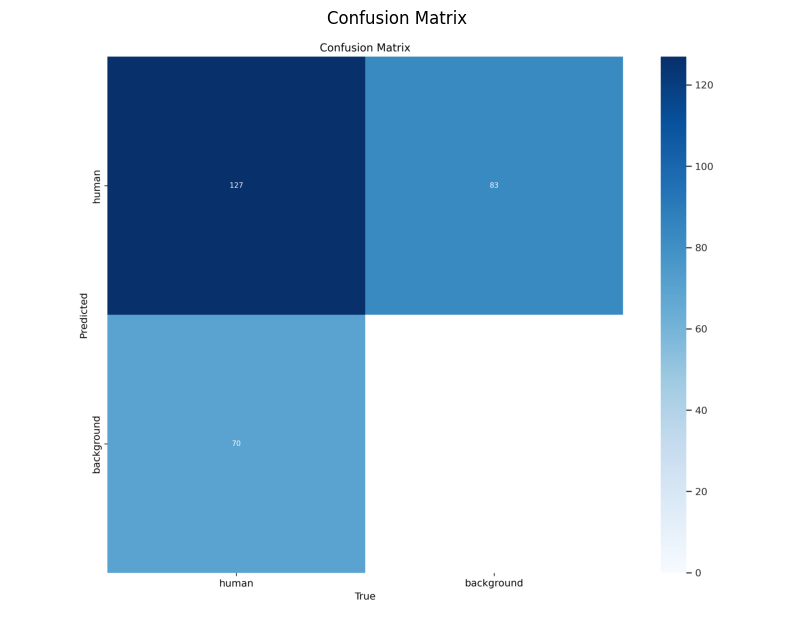

In [25]:
from PIL import Image
%matplotlib inline

confusion_matrix = Image.open('./runs/detect/yolo11m_heridal/confusion_matrix.png')
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix)
plt.title('Confusion Matrix')
plt.axis('off')
plt.show()

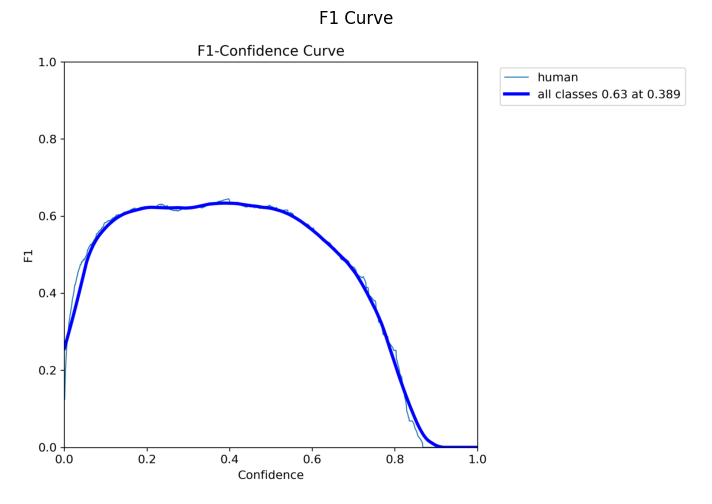

In [26]:
f1_curve = Image.open('./runs/detect/yolo11m_heridal/F1_curve.png')
plt.figure(figsize=(10, 6))
plt.imshow(f1_curve)
plt.title('F1 Curve')
plt.axis('off')
plt.show()

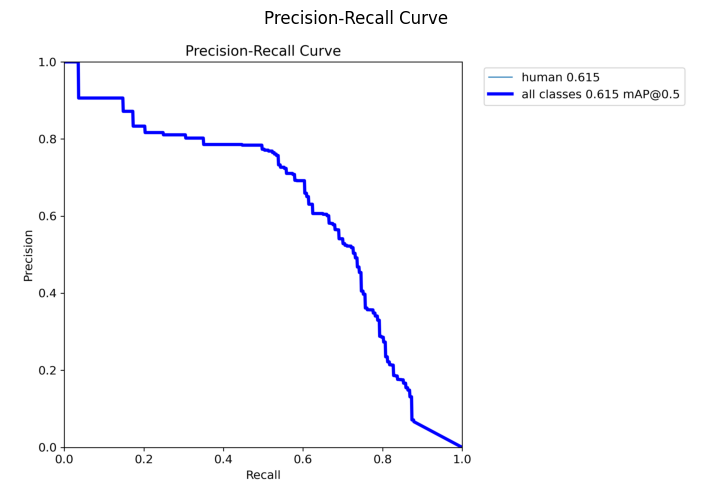

In [27]:
pr_curve = Image.open('./runs/detect/yolo11m_heridal/PR_curve.png')
plt.figure(figsize=(10, 6))
plt.imshow(pr_curve)
plt.title('Precision-Recall Curve')
plt.axis('off')
plt.show()


image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split/images/val/class0/train_GOR_2018_JPG.rf.e636d888595d2d7d174692f5619920ba.jpg: 768x1024 (no detections), 11.1ms
Speed: 18.9ms preprocess, 11.1ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)
0 0.197500 0.056333 0.020500 0.030000


image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split/images/val/class0/train_JAS_0084_JPG.rf.d8c622b811474f8af671a52b6be6251c.jpg: 768x1024 1 human, 12.4ms
Speed: 3.3ms preprocess, 12.4ms inference, 0.8ms postprocess per image at shape (1, 3, 768, 1024)
0 0.319875 0.606667 0.014250 0.022000


image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split/images/val/class0/train_BRK_2037_JPG.rf.e7484413ff040ac6cf04876062f2cbaf.jpg: 768x1024 2 humans, 11.3ms
Speed: 3.1ms preprocess, 11.3ms inference, 0.7ms postprocess per image at shape (1, 3, 768, 1024)
0 0.910375 0.721000 0.031250 0.022667



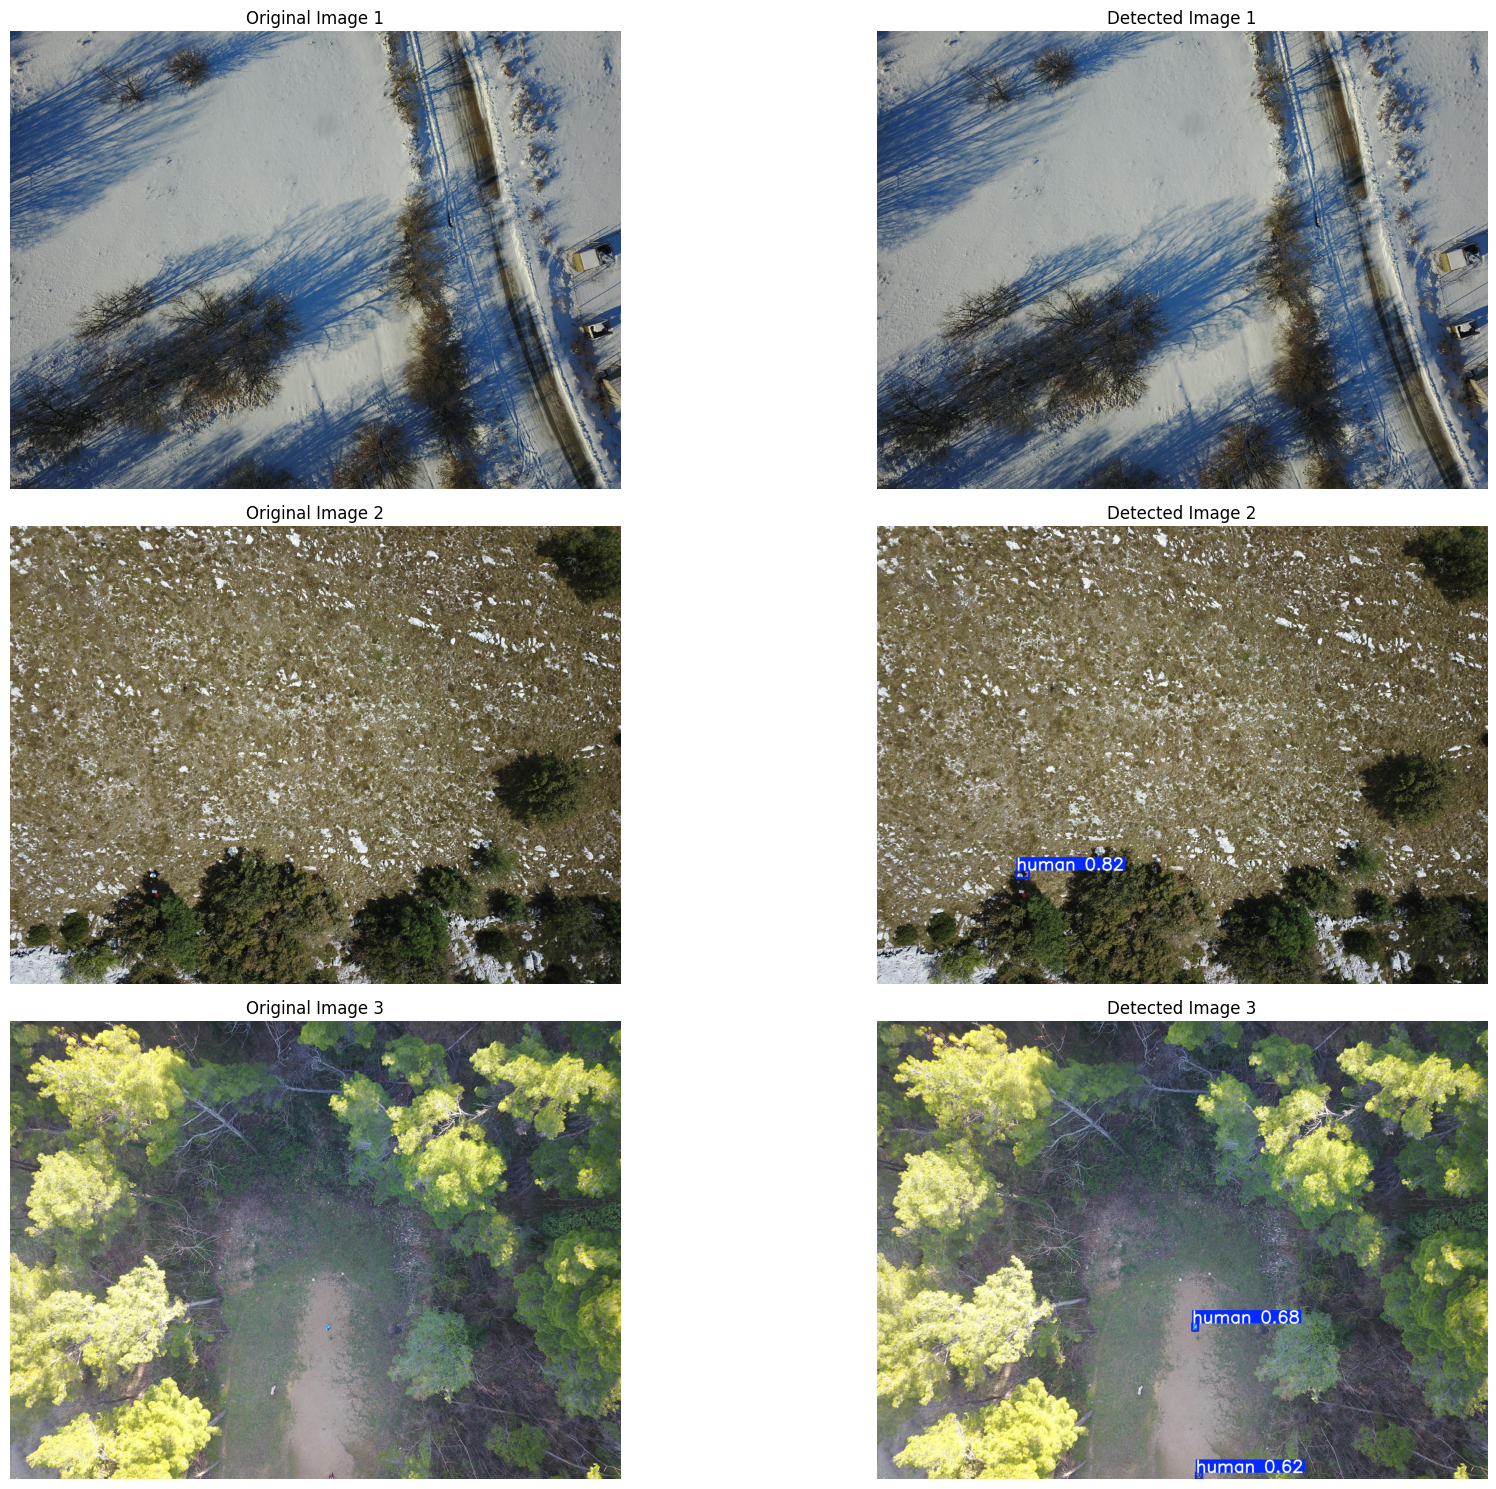

In [28]:
val_images = [os.path.join(VAL_DATA_DIR, f) for f in os.listdir(VAL_DATA_DIR) if f.endswith('.jpg')][:3]
val_labels = [os.path.join(LABELS_DIR_VAL, f) for f in os.listdir(LABELS_DIR_VAL) if f.endswith('.txt')][:3]

rm_folder_if_exists('./runs/detect/val2')

plt.figure(figsize=(20, 15))
for i, img_path in enumerate(val_images):
    results = best_model(img_path)
    
    plt.subplot(3, 2, 2*i+1)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(3, 2, 2*i+2)
    detected_img = results[0].plot()
    detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
    plt.imshow(detected_img)
    plt.title(f'Detected Image {i+1}')
    plt.axis('off')

    with open(val_labels[i], 'r') as lbl_file:
        print(lbl_file.read())

plt.tight_layout()
plt.show()